In [1]:
import sys

print(sys.version) 

3.12.1 (tags/v3.12.1:2305ca5, Dec  7 2023, 22:03:25) [MSC v.1937 64 bit (AMD64)]


In [2]:
# Import libraries
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np

## Off-the-shelf Model Exploration

In [3]:
# Load the dataset and display them 
dev_df = pd.read_csv('civility_data/dev.tsv', sep='\t')
mini_demographic_dev_df = pd.read_csv('civility_data/mini_demographic_dev.tsv', sep='\t')
dev_df.head()

,text,label,category,perspective_score
0,@USER She should ask a few native Americans wh...,OFF,UNT,0.311852
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,0.566334
2,Amazon is investigating Chinese employees who ...,NOT,NaN,0.110361
3,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,0.927032
4,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,0.319764


In [4]:
mini_demographic_dev_df.head()

,text,demographic,perspective_score
0,People make mistakes. It takes a good person t...,White,0.041031
1,"Only one on our road with power, but no cable ...",White,0.061435
2,I love when baby's yawn I think it's so cute.,White,0.056817
3,theres so many hoes now that i actually think ...,White,0.503459
4,Today is the day Adalynn Alexis will be here! ...,White,0.092183


In [5]:
# Set a threshold for perspective score as classifier
threshold = 0.5

# apply the threshold and create a new column predicted_label 
dev_df['predicted_label'] = dev_df['perspective_score'].apply(lambda x: 'OFF' if x > threshold else 'NOT')
# display it 
dev_df.head()

,text,label,category,perspective_score,predicted_label
0,@USER She should ask a few native Americans wh...,OFF,UNT,0.311852,NOT
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,0.566334,OFF
2,Amazon is investigating Chinese employees who ...,NOT,NaN,0.110361,NOT
3,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,0.927032,OFF
4,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,0.319764,NOT


In [6]:
# Then we are going to calculate the accuracy and other metrics for dev dataset
accuracy = accuracy_score(dev_df['label'], dev_df['predicted_label'])
precision, recall, f1, _ = precision_recall_fscore_support(dev_df['label'], dev_df['predicted_label'], average=None, labels=['OFF', 'NOT'])
macro_f1 = precision_recall_fscore_support(dev_df['label'], dev_df['predicted_label'], average='macro', labels=['OFF', 'NOT'])[2]
# Display the results
print("Accuracy:", accuracy)
print("Precision (OFF, NOT):", precision)
print("Recall (OFF, NOT):", recall)
print("F1 Score (OFF, NOT):", f1)
print("Macro F1 Score (OFF, NOT):", macro_f1)

Accuracy: 0.804380664652568
Precision (OFF, NOT): [0.69803063 0.86043829]
Recall (OFF, NOT): [0.725     0.8438914]
F1 Score (OFF, NOT): [0.71125975 0.85208452]
Macro F1 Score (OFF, NOT): 0.7816721389338279


In [7]:
# Now move to the mini_demographic_dev dataset, 
# and since all data contains no toxic tweets, we can add another column as true_label
mini_demographic_dev_df['true_label'] = 'NOT'

# then use the threshold to get predicted label 
mini_demographic_dev_df['predicted_label'] = mini_demographic_dev_df['perspective_score'].apply(lambda x: 'OFF' if x > threshold else 'NOT')
# display it
mini_demographic_dev_df.head()

,text,demographic,perspective_score,true_label,predicted_label
0,People make mistakes. It takes a good person t...,White,0.041031,NOT,NOT
1,"Only one on our road with power, but no cable ...",White,0.061435,NOT,NOT
2,I love when baby's yawn I think it's so cute.,White,0.056817,NOT,NOT
3,theres so many hoes now that i actually think ...,White,0.503459,NOT,OFF
4,Today is the day Adalynn Alexis will be here! ...,White,0.092183,NOT,NOT


In [8]:
# Then lets calculate its FPR for each demographic group
# A dictionary with demographic as key, and their FPR as value
fpr_demographics = {}
for demographic in mini_demographic_dev_df['demographic'].unique():
    # Subset by demographic group
    demo_data = mini_demographic_dev_df[mini_demographic_dev_df['demographic'] == demographic]
    # Calculate false positives (predicted 'OFF' when true label is 'NOT')
    false_positives = sum(demo_data['predicted_label'] == 'OFF')
    total = len(demo_data)
    fpr_demographics[demographic] = false_positives / total if total > 0 else 0

# Display the FPR results for each demographic
fpr_demographics


{'White': 0.15206611570247933,
 'Hispanic': 0.17313432835820897,
 'AA': 0.2740963855421687,
 'Other': 0.058823529411764705}

## Custom Model Exploration

In [9]:
# Load the training data
train_df = pd.read_csv('./civility_data/train.tsv', sep='\t')
train_df.head()

,text,label,category
0,@USER @USER You are an embarrassing citizen!!,OFF,TIN
1,@USER Seems hard to believe that you stood nex...,OFF,TIN
2,@USER @USER @USER Wow !!! no wonder the Libera...,OFF,TIN
3,@USER @USER And not all idiots grandstands lik...,OFF,TIN
4,@USER Bring on the hypocrite gungrabber. MAGA,OFF,TIN


In [10]:
# Import necessary packages
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression


In [11]:
# Extract the text data and labels for training and dev sets
X_train_texts = train_df['text']
y_train_labels = train_df['label']

X_dev_texts = dev_df['text']
y_dev_labels = dev_df['label']

In [12]:
# Initialize the TF-IDF Vectorizer to convert text into numerical data with n-grams (unigrams and bigrams)
# vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=7000,
    min_df=5, # terms that appear in fewer than 5 documents are ignored.
    max_df=0.7, # terms appearing in more than 70% of documents are ignored
    sublinear_tf=True
)
# Fit the vectorizer on the training text and transform both training and dev texts
X_train = vectorizer.fit_transform(X_train_texts)
X_dev = vectorizer.transform(X_dev_texts)

# Initialize the logistic regression model and train it on the vectorized training data
# model = LogisticRegression(max_iter=1000)
model = LogisticRegression(
    max_iter=10000,
    C=0.7,
    class_weight='balanced',
    solver='saga', # improve performance by enforcing sparsity in the coefficients, potentially eliminating uninformative features
    penalty='l1', # improve interpretability by zeroing out less important features
    random_state=42
)
model.fit(X_train, y_train_labels)

# Default prediction using threshold of 0.5
# y_dev_pred = model.predict(X_dev)

# Define custom threshold for the 'OFF' class
custom_threshold = 0.5  # You can adjust this value

# Get the predicted probabilities for each class OFF/NOT
y_dev_probs = model.predict_proba(X_dev)

# Apply the custom threshold to predict labels
y_dev_pred = ['OFF' if prob[1] >= custom_threshold else 'NOT' for prob in y_dev_probs]

In [13]:
# Calculate accuracy
accuracy = accuracy_score(y_dev_labels, y_dev_pred)

# Calculate precision, recall, and F1 score for both classes off/not
precision, recall, f1, _ = precision_recall_fscore_support(y_dev_labels, y_dev_pred, labels=['OFF', 'NOT'])
macro_f1 = precision_recall_fscore_support(y_dev_labels, y_dev_pred, labels=['OFF', 'NOT'], average='macro')[2]

# Display the performance metrics for both classes
performance_metrics = {
    "Accuracy": accuracy,
    "Precision (OFF)": precision[0],
    "Precision (NOT)": precision[1],
    "Recall (OFF)": recall[0],
    "Recall (NOT)": recall[1],
    "F1 Score (OFF)": f1[0],
    "F1 Score (NOT)": f1[1],
    "Macro F1 Score": macro_f1
}
performance_metrics

{'Accuracy': 0.7522658610271903,
 'Precision (OFF)': 0.6435897435897436,
 'Precision (NOT)': 0.797644539614561,
 'Recall (OFF)': 0.5704545454545454,
 'Recall (NOT)': 0.8427601809954751,
 'F1 Score (OFF)': 0.6048192771084338,
 'F1 Score (NOT)': 0.8195819581958196,
 'Macro F1 Score': 0.7122006176521267}

In [14]:
# Overall fpr calculation
X_new_texts = mini_demographic_dev_df['text']
X_new = vectorizer.transform(X_new_texts)
y_new_pred = model.predict(X_new)
y_true = ["NOT"] * len(y_new_pred)
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_true, y_new_pred, labels=["NOT", "OFF"]).ravel()
# Calculate FPR: FPR = FP / (FP + TN)
fpr = fp / (fp + tn)
fpr

0.18966876971608831

In [15]:
X_mini_demo_texts = mini_demographic_dev_df['text']  # Text data for predictions
X_mini_demo = vectorizer.transform(X_mini_demo_texts)  # Transforming using the TF-IDF vectorizer
y_mini_demo_pred = model.predict(X_mini_demo)  # Getting predictions
mini_demographic_dev_df['custom_predicted_label'] = y_mini_demo_pred

fpr_demographics = {}
for demographic in mini_demographic_dev_df['demographic'].unique():
    # Subset the data by demographic group
    demo_data = mini_demographic_dev_df[mini_demographic_dev_df['demographic'] == demographic]
    
    # Calculate false positives where 'predicted_label' is 'OFF' but 'true_label' is 'NOT'
    false_positives = sum(demo_data['custom_predicted_label'] == 'OFF')
    total = len(demo_data)
    
    # Calculate FPR for the demographic group
    fpr_demographics[demographic] = false_positives / total if total > 0 else 0

# Display the FPR results for each demographic group
fpr_demographics

{'White': 0.18937426210153482,
 'Hispanic': 0.19701492537313434,
 'AA': 0.28313253012048195,
 'Other': 0.0}

In [16]:
# Store the test dataset by baseline custom model 
test_df = pd.read_csv('./civility_data/test.tsv', sep='\t')
X_test_text = vectorizer.transform(test_df['text'])
y_test_pred_baseline = model.predict(X_test_text)
baseline_test_df = test_df[['text']].copy()
baseline_test_df['label'] = y_test_pred_baseline

baseline_filename = "Haoshen_Wu_test.tsv"
baseline_test_df[['text', 'label']].to_csv(baseline_filename, sep='\t', index=False)

In [17]:
# Explore what kind of thing get mispredicted as OFF
mini_demographic_dev_df[mini_demographic_dev_df['custom_predicted_label'] == 'OFF']

,text,demographic,perspective_score,true_label,predicted_label,custom_predicted_label
7,Gotta dawg ass headache.,AA,0.760669,NOT,OFF,OFF
8,fav if you tryna straighten my hair for mw thi...,White,0.188703,NOT,NOT,OFF
16,finally watching elf holy shit,White,0.902681,NOT,OFF,OFF
28,I rather have no friends then a bunch of fake ...,White,0.464164,NOT,NOT,OFF
34,Is it rude if i go out and take foul shots at ...,White,0.193304,NOT,NOT,OFF
...,...,...,...,...,...,...
5046,I hate this so much. I wish I could rewind,White,0.348931,NOT,NOT,OFF
5053,Jacob is confusing me..,White,0.118868,NOT,NOT,OFF
5061,I literally hate Thursdays because of all the ...,White,0.369332,NOT,NOT,OFF
5063,Ain't do shit,AA,0.933319,NOT,OFF,OFF


In [18]:
# Test matrics on train data ifself 
X_temp_texts = train_df['text']
y_temp_labels = train_df['label']
X_temp = vectorizer.transform(X_temp_texts)

y_temp_pred = model.predict(X_temp)


accuracy = accuracy_score(y_temp_labels, y_temp_pred)

# Calculate precision, recall, and F1 score for both classes (OFF and NOT)
precision, recall, f1, _ = precision_recall_fscore_support(y_temp_labels, y_temp_pred, labels=['OFF', 'NOT'])
macro_f1 = precision_recall_fscore_support(y_temp_labels, y_temp_pred, labels=['OFF', 'NOT'], average='macro')[2]

# Display the performance metrics for both classes
performance_metrics = {
    "Accuracy": accuracy,
    "Precision (OFF)": precision[0],
    "Precision (NOT)": precision[1],
    "Recall (OFF)": recall[0],
    "Recall (NOT)": recall[1],
    "F1 Score (OFF)": f1[0],
    "F1 Score (NOT)": f1[1],
    "Macro F1 Score": macro_f1
}
performance_metrics

{'Accuracy': 0.7808723564954683,
 'Precision (OFF)': 0.679008659301284,
 'Precision (NOT)': 0.8279718348750518,
 'Recall (OFF)': 0.6460227272727272,
 'Recall (NOT)': 0.8479920814479638,
 'F1 Score (OFF)': 0.6621051099141069,
 'F1 Score (NOT)': 0.8378623821166609,
 'Macro F1 Score': 0.7499837460153839}

In [19]:
# Retrieve the feature names (words/bigrams) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Retrieve the coefficients from the logistic regression model
# Since we have two classes, 'OFF' and 'NOT', we examine coefficients for 'OFF'
coefficients = model.coef_[0]

# Get the indices of the sorted coefficients for positive and negative influence
top_positive_coefficients = np.argsort(coefficients)[-100:]  # Most positive (for "OFF")
top_negative_coefficients = np.argsort(coefficients)[:10]   # Most negative (for "NOT")

# Map these indices back to feature names
top_features_off = [(feature_names[i], coefficients[i]) for i in top_positive_coefficients]
top_features_not = [(feature_names[i], coefficients[i]) for i in top_negative_coefficients]

# Display the results
top_features_off, top_features_not

([('white people', 1.2053582221016301),
  ('mentally', 1.2112747678054507),
  ('nazi', 1.219655771454955),
  ('lie', 1.3210574815825096),
  ('go away', 1.3591937720739904),
  ('silly', 1.364428639089652),
  ('self', 1.367354805919066),
  ('liberals are', 1.3803044851845936),
  ('men', 1.3982690482106193),
  ('should be', 1.4055915143803355),
  ('obama', 1.4106700306345377),
  ('fools', 1.495573174210719),
  ('awful', 1.5486491399080096),
  ('is', 1.558690147201132),
  ('garbage', 1.5662095781511944),
  ('boobs', 1.581877021347942),
  ('niggas', 1.6201322421793212),
  ('are', 1.6262922929282781),
  ('because you', 1.6500995269794947),
  ('assholes', 1.658600355625115),
  ('like you', 1.6813805814670144),
  ('moron', 1.688943886463472),
  ('sexual', 1.6988705592802766),
  ('stupidity', 1.7067261802941185),
  ('liars', 1.7223260982603998),
  ('slave', 1.730717441457448),
  ('pedo', 1.744600249010687),
  ('porn', 1.790355855960268),
  ('they', 1.8008195838831533),
  ('nuts', 1.803227427683

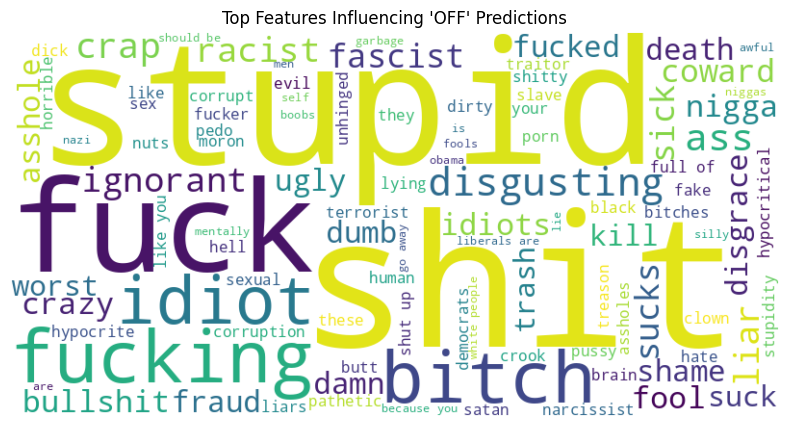

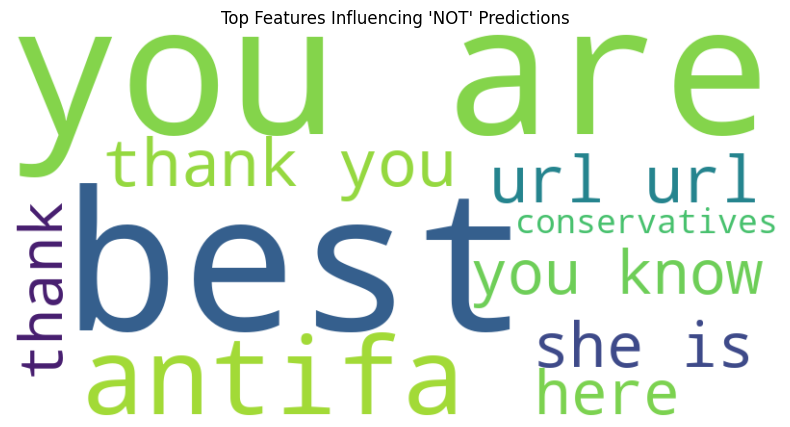

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# For "OFF" (Top positive features)
off_words = {word: abs(coef) for word, coef in top_features_off}

# For "NOT" (Top negative features)
not_words = {word: abs(coef) for word, coef in top_features_not}

# Create word clouds
def plot_wordcloud(word_dict, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_dict)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Display word clouds
plot_wordcloud(off_words, "Top Features Influencing 'OFF' Predictions")
plot_wordcloud(not_words, "Top Features Influencing 'NOT' Predictions")


* Advanced Section
* SVM
* MLPClassifier


In [21]:
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load new training data with perspective scores
train_with_toxicity_scores_df = pd.read_csv('./civility_data/train_with_toxicity_scores22.tsv', sep='\t')
train_df = train_with_toxicity_scores_df.copy()  # to ensure compatibility with the variable naming

# Vectorize the text data with TF-IDF
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=7000,
    min_df=5,
    max_df=0.7,
    sublinear_tf=True
)
X_train_text = vectorizer.fit_transform(train_df['text'])
X_dev_text = vectorizer.transform(dev_df['text'])

# Extract the toxicity scores as additional features
X_train_toxicity = train_df['toxicity_score'].values.reshape(-1, 1)
X_dev_toxicity = dev_df['perspective_score'].values.reshape(-1, 1)  # use the dev set's perspective scores as well

# Combine TF-IDF features with toxicity scores
X_train_combined = hstack([X_train_text, X_train_toxicity])
X_dev_combined = hstack([X_dev_text, X_dev_toxicity])

# Train logistic regression on the combined features
model = LogisticRegression(
    max_iter=5000,
    C=1.5,
    class_weight='balanced',
    solver='saga',
    penalty='l1',
    random_state=42
)
model.fit(X_train_combined, train_df['label'])

# Predict and evaluate on dev set
y_dev_pred = model.predict(X_dev_combined)
accuracy = accuracy_score(y_dev_labels, y_dev_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_dev_labels, y_dev_pred, labels=['OFF', 'NOT'])
macro_f1 = precision_recall_fscore_support(y_dev_labels, y_dev_pred, labels=['OFF', 'NOT'], average='macro')[2]

# Display updated performance metrics with the toxicity score feature
advanced_performance_metrics = {
    "Accuracy": accuracy,
    "Precision (OFF)": precision[0],
    "Precision (NOT)": precision[1],
    "Recall (OFF)": recall[0],
    "Recall (NOT)": recall[1],
    "F1 Score (OFF)": f1[0],
    "F1 Score (NOT)": f1[1],
    "Macro F1 Score": macro_f1
}
advanced_performance_metrics


{'Accuracy': 0.7061933534743202,
 'Precision (OFF)': 0.5345997286295794,
 'Precision (NOT)': 0.9216354344122658,
 'Recall (OFF)': 0.8954545454545455,
 'Recall (NOT)': 0.6119909502262444,
 'F1 Score (OFF)': 0.6694987255734919,
 'F1 Score (NOT)': 0.7355540448674371,
 'Macro F1 Score': 0.7025263852204645}

In [22]:
# Store the advanced model using perspective and TFIDF features (logistic regression)
test_df = pd.read_csv('./civility_data/test_with_perspectiveScore.tsv', sep='\t')
# Prepare test data for the advanced model (TF-IDF + toxicity score)
X_test_toxicity = test_df['toxicity_score'].values.reshape(-1, 1)
X_test_combined = hstack([X_test_text, X_test_toxicity])

# Advanced custom model predictions on test data
y_test_pred_advanced = model.predict(X_test_combined)

# Create DataFrame for advanced prediction file
advanced_test_df = test_df[['text']].copy()
advanced_test_df['label'] = y_test_pred_advanced

# Save the advanced predictions
advanced_filename = "Haoshen_Wu_advanced.tsv"
advanced_test_df[['text', 'label']].to_csv(advanced_filename, sep='\t', index=False)

**Just for testing other model**
Exploring part, didn't mentioned in the writeup

In [23]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42)

svm_model.fit(X_train_combined, train_df['label'])

y_dev_pred_svm = svm_model.predict(X_dev_combined)

accuracy_svm = accuracy_score(y_dev_labels, y_dev_pred_svm)
precision_svm, recall_svm, f1_svm, _ = precision_recall_fscore_support(y_dev_labels, y_dev_pred_svm, labels=['OFF', 'NOT'])
macro_f1_svm = precision_recall_fscore_support(y_dev_labels, y_dev_pred_svm, labels=['OFF', 'NOT'], average='macro')[2]

# Display SVM performance metrics
svm_performance_metrics = {
    "Accuracy": accuracy_svm,
    "Precision (OFF)": precision_svm[0],
    "Precision (NOT)": precision_svm[1],
    "Recall (OFF)": recall_svm[0],
    "Recall (NOT)": recall_svm[1],
    "F1 Score (OFF)": f1_svm[0],
    "F1 Score (NOT)": f1_svm[1],
    "Macro F1 Score": macro_f1_svm
}
svm_performance_metrics


{'Accuracy': 0.7061933534743202,
 'Precision (OFF)': 0.5352697095435685,
 'Precision (NOT)': 0.9118136439267887,
 'Recall (OFF)': 0.8795454545454545,
 'Recall (NOT)': 0.6199095022624435,
 'F1 Score (OFF)': 0.6655202063628547,
 'F1 Score (NOT)': 0.7380471380471381,
 'Macro F1 Score': 0.7017836722049964}

In [24]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(
    hidden_layer_sizes=(100,),  
    max_iter=300,               
    activation='relu',
    solver='adam', 
    random_state=42
)

# Train on the combined features
mlp_model.fit(X_train_combined, train_df['label'])

# Predict on the dev set
y_dev_pred_mlp = mlp_model.predict(X_dev_combined)

accuracy_mlp = accuracy_score(y_dev_labels, y_dev_pred_mlp)
precision_mlp, recall_mlp, f1_mlp, _ = precision_recall_fscore_support(y_dev_labels, y_dev_pred_mlp, labels=['OFF', 'NOT'])
macro_f1_mlp = precision_recall_fscore_support(y_dev_labels, y_dev_pred_mlp, labels=['OFF', 'NOT'], average='macro')[2]

# Display MLP performance metrics
mlp_performance_metrics = {
    "Accuracy": accuracy_mlp,
    "Precision (OFF)": precision_mlp[0],
    "Precision (NOT)": precision_mlp[1],
    "Recall (OFF)": recall_mlp[0],
    "Recall (NOT)": recall_mlp[1],
    "F1 Score (OFF)": f1_mlp[0],
    "F1 Score (NOT)": f1_mlp[1],
    "Macro F1 Score": macro_f1_mlp
}
mlp_performance_metrics


{'Accuracy': 0.6941087613293051,
 'Precision (OFF)': 0.5292153589315526,
 'Precision (NOT)': 0.8303448275862069,
 'Recall (OFF)': 0.7204545454545455,
 'Recall (NOT)': 0.6809954751131222,
 'F1 Score (OFF)': 0.6102021174205967,
 'F1 Score (NOT)': 0.7482908638906153,
 'Macro F1 Score': 0.6792464906556059}